## Load landslide dataset

In [1]:
from __future__ import division
import pandas as pd

df = pd.read_csv('landslides_remote_sensing.csv')
X = df.values
print df.head()

   landslide  elevation  aspect  slope   wetness      ndvi      ndwi  \
0        0.0     5242.0   335.0   14.0  0.320446 -0.013182  0.606071   
1        0.0     5718.0     8.0   21.0  0.376848 -0.048040  0.817809   
2        0.0     6008.0    85.0   12.0  0.376848 -0.025214  0.596792   
3        0.0     5759.0   181.0   15.0  0.376848 -0.032129  0.723321   
4        0.0     5491.0   191.0   14.0  0.376848 -0.029776  0.808161   

   curvature  
0        0.0  
1     -186.0  
2     -539.0  
3      -19.0  
4       52.0  


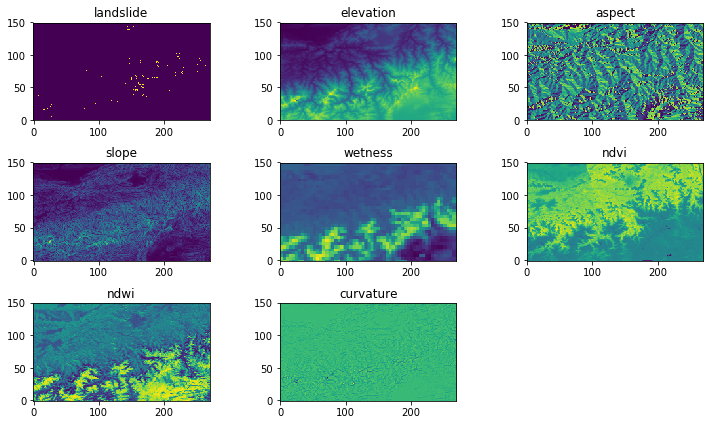

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


names = df.columns.values

fig = plt.figure(figsize = (12, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, name in enumerate(names):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(X[:, i].reshape((270, 150)).T, origin='lower')
    ax.set_title(name)

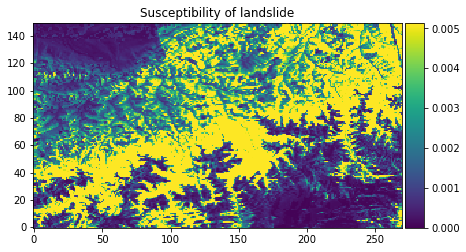

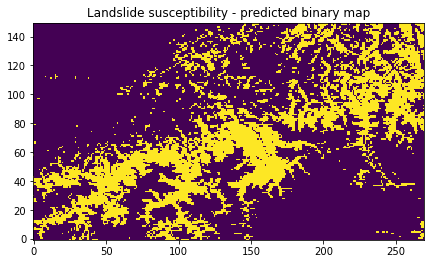

In [3]:
from sklearn.linear_model import LogisticRegression

y = X[:, 0] ## landslides
X = X[:, 1:] ## predictors

lr = LogisticRegression(C=1.0, penalty='l1', class_weight=None).fit(X,y)
probas = lr.predict_proba(X).reshape((270, 150, 2))
prob_landslide = probas[:, :, 1].T
threshold = sum(y) / y.shape
y_pred = prob_landslide.copy()
y_pred[y_pred <= threshold] = 0
y_pred[y_pred > threshold] = 1

plt.figure(figsize=(7, 7))
ax = plt.gca()
im = plt.imshow(prob_landslide, origin='lower', vmin=0, vmax=threshold)
plt.title('Susceptibility of landslide')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

plt.figure(figsize=(7, 7))
plt.imshow(y_pred, origin='lower', vmin=0, vmax=1)
plt.title('Landslide susceptibility - predicted binary map')

In [4]:
from sklearn.metrics import confusion_matrix as cr
target_names = ['0', '1']
print cr(y, y_pred.flatten(order='F'), labels=[0, 1])

[[29162 11130]
 [   38   170]]


# Perform PCA on data after scanning with 5x5 template

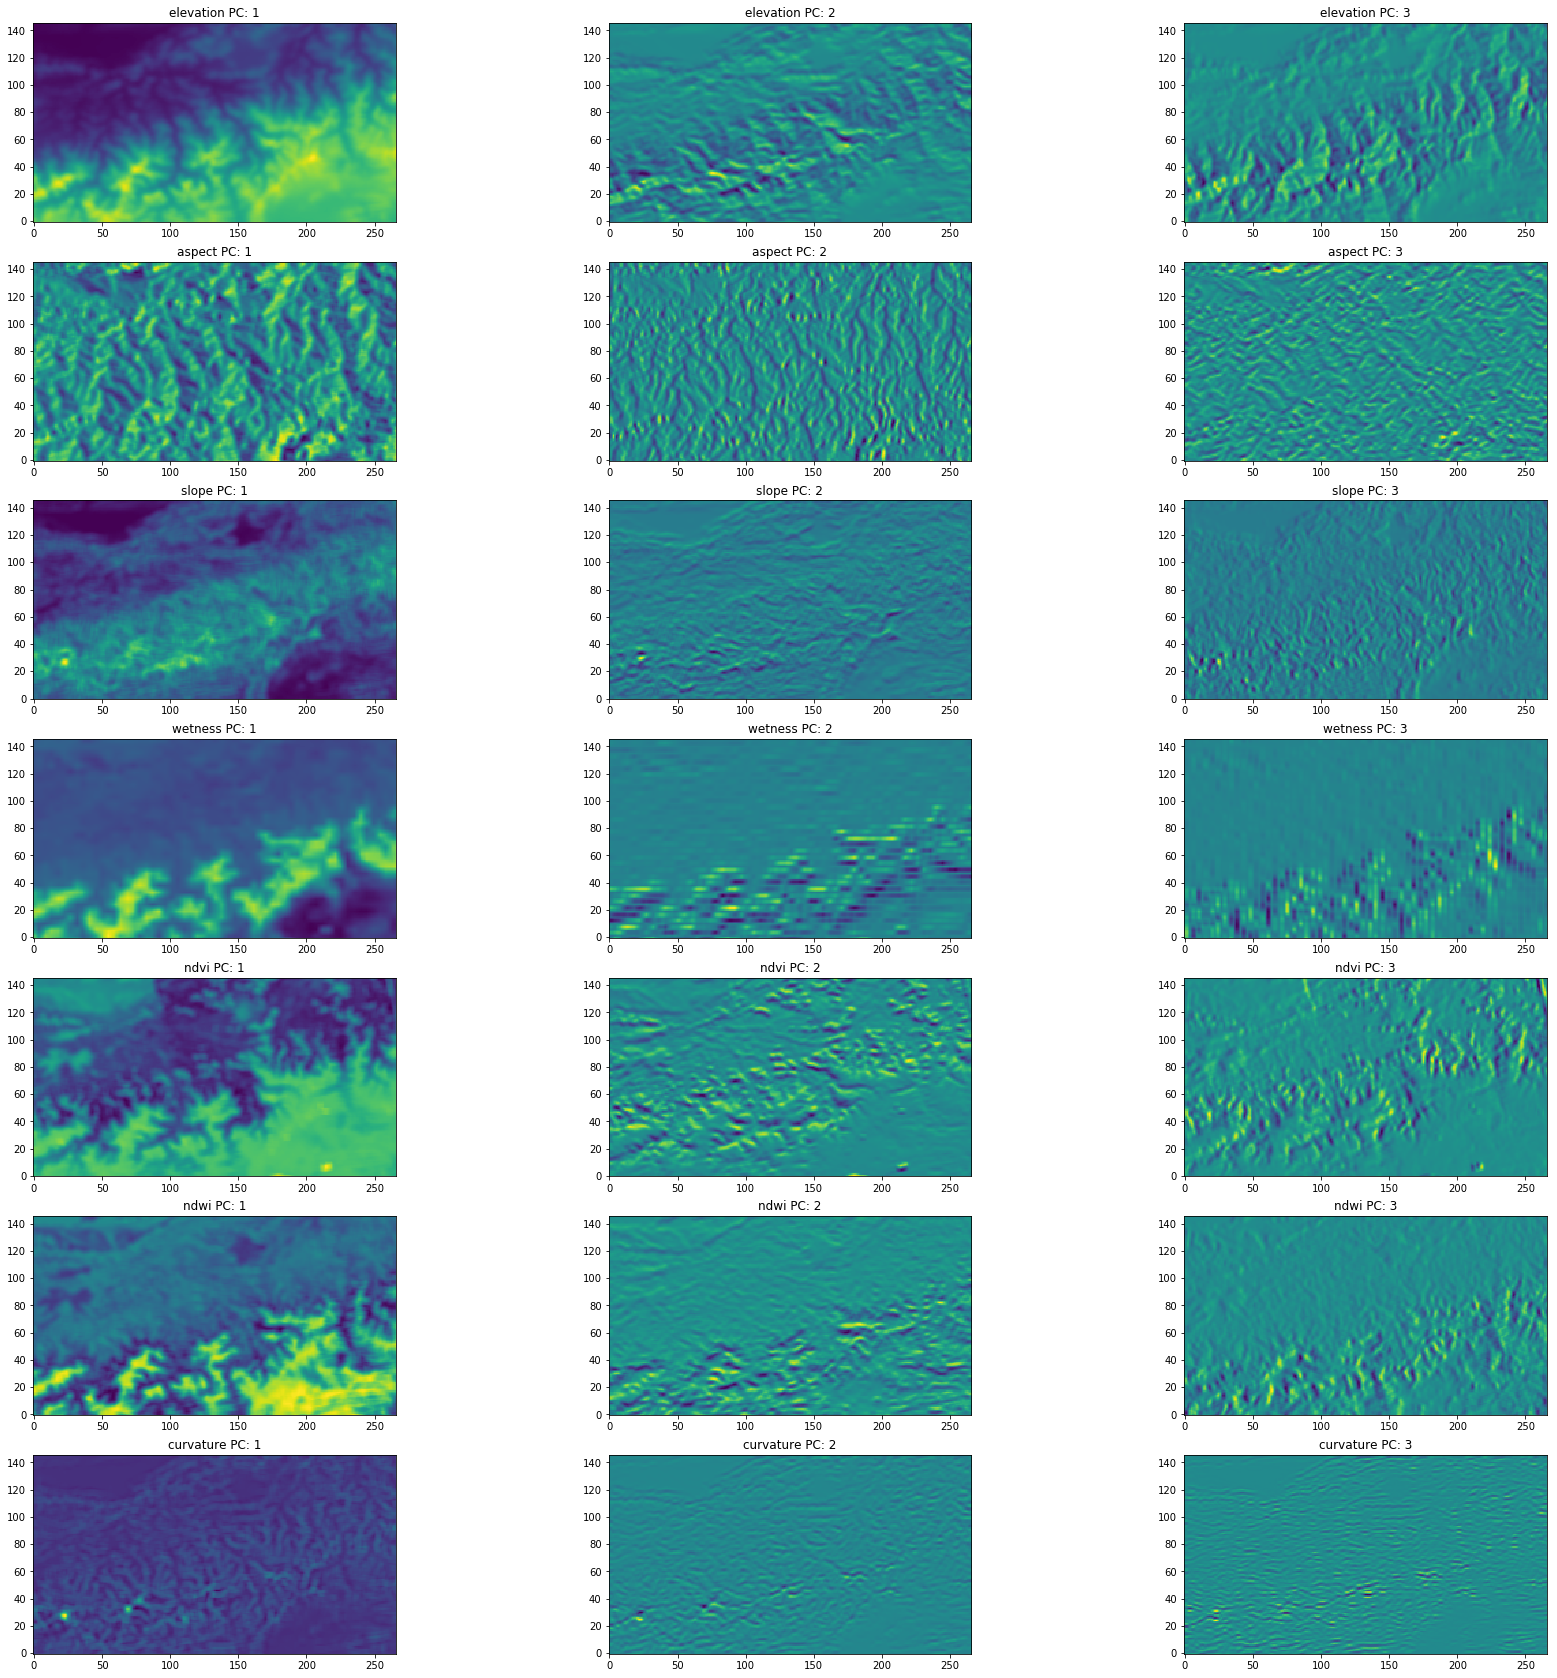

In [5]:
import numpy as np
from sklearn.decomposition import PCA

def slide_template(X):
    X = X.reshape((270, 150)).T
    newX = []
    for col in range(X.shape[1] - 4):
        for row in range(X.shape[0] - 4):
            window = []
            for k in range(5):
                for l in range(5):
                    window.append(X[row + k, col + l])
            newX.append(window)
    newX = np.asarray(newX)
    return newX

def performPCA(X):
    pca = PCA(n_components = 3)
    scores = pca.fit_transform(X)
    return scores, pca.explained_variance_ratio_

predictor_names = names[1:]

fig = plt.figure(figsize = (30, 30))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
subplot = 1
for i, name in enumerate(predictor_names):
    X1 = slide_template(X[:, i])
    X1_scores, var = performPCA(X1)
    for j in range(3):
        ax = fig.add_subplot(7, 3, subplot)
        ax.imshow(X1_scores[:, j].reshape((266, 146)).T, origin='lower')
        ax.set_title(name + ' PC: ' + str(j + 1))
        subplot = subplot + 1
    

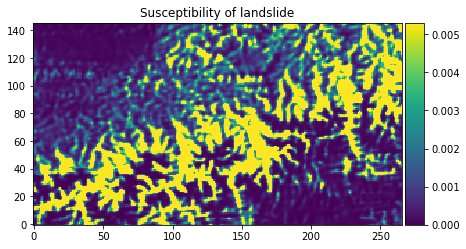

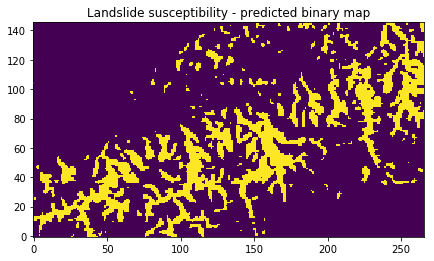

In [6]:
y = y.reshape((270, 150)).T
y = y[:-4, :-4]
y = y.flatten('F')
X_new = []
for i, name in enumerate(predictor_names):
    X1 = slide_template(X[:, i])
    X1_scores, var = performPCA(X1)
    X_new.append(X1_scores[:,0])
    X_new.append(X1_scores[:,1])
    X_new.append(X1_scores[:,2])
X_new = np.asarray(X_new).T

lr = LogisticRegression(C=1.0, penalty='l1', class_weight=None).fit(X_new,y)
probas = lr.predict_proba(X_new).reshape((266, 146, 2))
prob_landslide = probas[:, :, 1].T
threshold = sum(y) / y.shape
y_pred = prob_landslide.copy()
y_pred[y_pred <= threshold] = 0
y_pred[y_pred > threshold] = 1

plt.figure(figsize=(7, 7))
ax = plt.gca()
im = plt.imshow(prob_landslide, origin='lower', vmin=0, vmax=threshold)
plt.title('Susceptibility of landslide')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

plt.figure(figsize=(7, 7))
plt.imshow(y_pred, origin='lower', vmin=0, vmax=1)
plt.title('Landslide susceptibility - predicted binary map')

In [7]:
print cr(y, y_pred.flatten(order='F'), labels=[0, 1])

[[31290  7340]
 [   32   174]]
